# F: Cancelación de ruido con Python y la transformada de Fourier

Parte de este `notebook` está basado en [Noise cancellation with Python and Fourier Transform](https://towardsdatascience.com/noise-cancellation-with-python-and-fourier-transform-97303314aa71)

Mostraremos como cómo utilizar una herramienta "muy sencilla" como es la [Transformada de Fourier](https://es.wikipedia.org/wiki/Transformada_de_Fourier) para obtener una cancelación de ruido eficiente, con pocas líneas de código.

Modelar el ruido es una tarea realmente difícil. Con los avances tecnológicos que la informática ha experimentado durante los años, se han obtenido grandes rendimientos de los algoritmos de *de-noising* de *Machine (Deep) Learning*. Si bien estos métodos permiten obtener resultados increíbles, a veces se pueden utilizar enfoques muy simples basados en consideraciones extremadamente razonables y generales para resolver el problema de la cancelación de ruido con excelentes resultados.

Un ejemplo importante de este concepto es el enfoque de *de-noising* de *Fourier*.

## *De-noising* de Fourier

Digamos que tienes una señal que, matemáticamente hablando, puede considerarse como una función de un espacio real a un número real: $$y: \mathbb R \rightarrow \mathbb R$$

La idea de la transformada de Fourier es estudiar esta señal en otro dominio.
Más concretamente, el dominio que utiliza es el de la frecuencia, obteniendo así: $$y: \mathbb C \rightarrow \mathbb R$$

La idea fundamental es que puedes descomponer tu señal como una suma discreta (o una suma continua, es decir, una integral) de senos y cosenos, considerados con sus amplitudes específicas.

Supongamos que tienes esta señal:

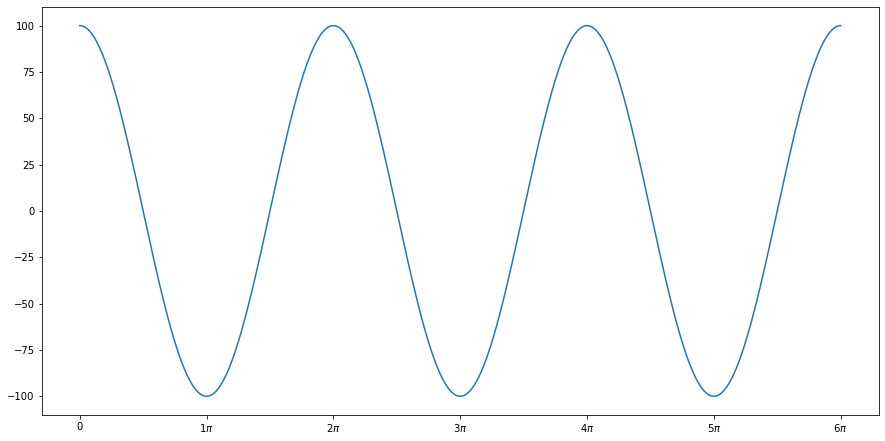

In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MultipleLocator

import numpy as np  
import scipy.fft

plt.rcParams["figure.figsize"] = (15,7.5)

x = np.linspace(0, 2 * 3 * np.pi, num=1080)

y = 100*np.cos(x)

ax = plt.gca()                                                               # Para la leyenda de X como múltiplos de PI
ax.xaxis.set_major_formatter(FuncFormatter(                                  #
    lambda val, pos: '{:.0f}$\pi$'.format(val / np.pi) if val != 0 else '0'  #
))                                                                           #
ax.xaxis.set_major_locator(MultipleLocator(base=np.pi))                      #

plt.plot(x, y)
plt.show()

Eso significa que su señal es $y$:

$$y = sin(x),\:donde\: 0 < x<8\pi$$

Ahora, como esta señal es sólo un seno, tendremos que, en el espacio de Fourier, se ve así:

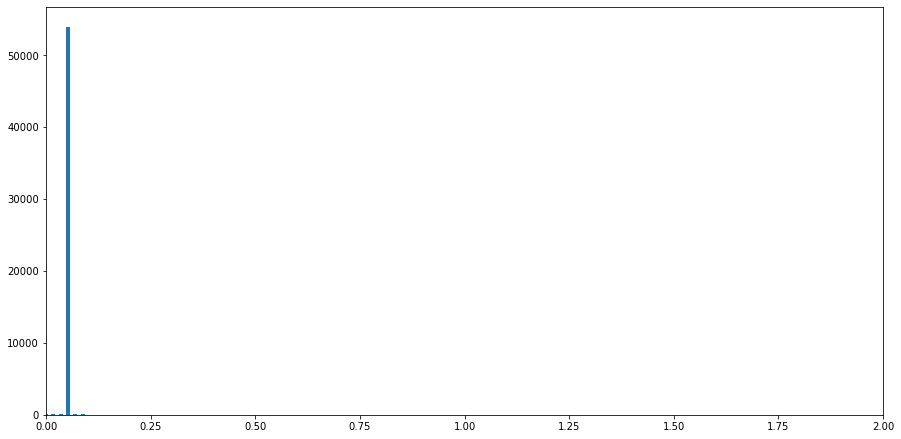

In [2]:
y_f = abs(scipy.fft.fft(y))

plt.bar(x, y_f, width = 0.01)

plt.xlim(0, 2)
plt.show()

Se puede volver fácilmente a la función original utilizando la transformada rápida de Fourier inversa `scipy.fft.ifft()`.

Entonces, ¿por qué hablamos de cancelación de ruido?

Una suposición segura (y general) es que el ruido puede sobrevivir en todas las frecuencias, mientras quela señal está limitada en el espectro de frecuencias (es decir, limitada en banda) y sólo tiene ciertas frecuencias específicas no nulas que la caracterizan.

Generemos unos nuevos datos de un coseno muy ruidoso:

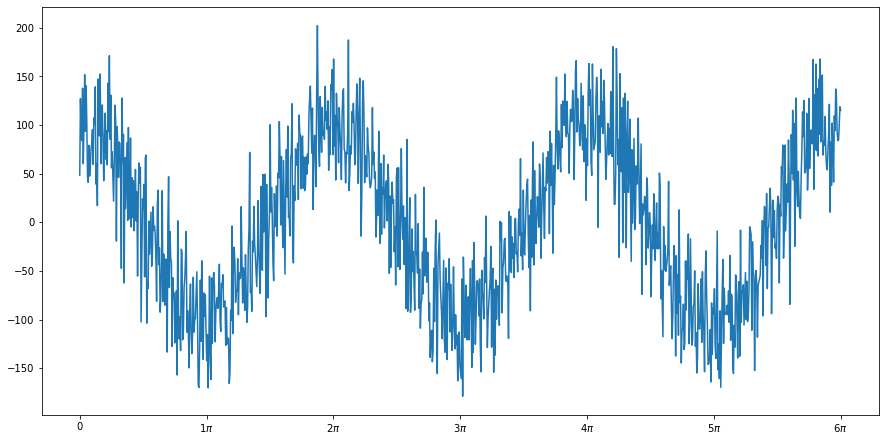

In [3]:
x = np.linspace(0, 6 * np.pi, num=1080)
n = np.random.normal(scale=40, size=x.size)

y = 100 * np.cos(x) + n

plt.Figure(figsize=(1, 1.5), dpi=80)
plt.plot(x, y)

ax = plt.gca()
ax.xaxis.set_major_formatter(FuncFormatter(
    lambda val, pos: '{:.0f}$\pi$'.format(val / np.pi) if val != 0 else '0'
))
ax.xaxis.set_major_locator(MultipleLocator(base=np.pi))


plt.savefig("salidas/noisey_sine.png", dpi=80)
plt.show()

Hacemos la transformada de Fourier y vemos que evidentemente la frecuencia del coseno está muy presente y el ruido es una composición de frecuencias con mucha menos intensidad.

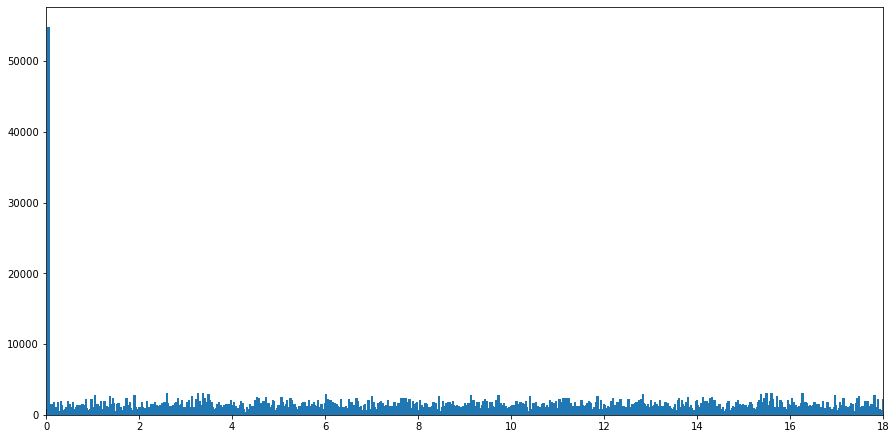

In [4]:
y_f = abs(scipy.fft.fft(y))

plt.bar(x, y_f, width = 0.05)
plt.xlim(0, 18)
plt.show()

Una suposición general que hay que hacer es que la señal y el ruido no están correlacionados, y que, aunque la señal sea ruidosa, la parte "no ruidosa" de la señal es dominante.
Así que la idea principal es encontrar las frecuencias reales de la señal y obtener una señal reconstruida utilizando sólo las frecuencias importantes de la señal. Las "frecuencias no relevantes", que se van a encontrar utilizando los valores de correlación, se pondrán a `0`. En nuestro caso vamos a poner a `0` todas las frecuencias por debajo de `4000` (básicamente todas las frecuencias menos la componente principal del coseno):

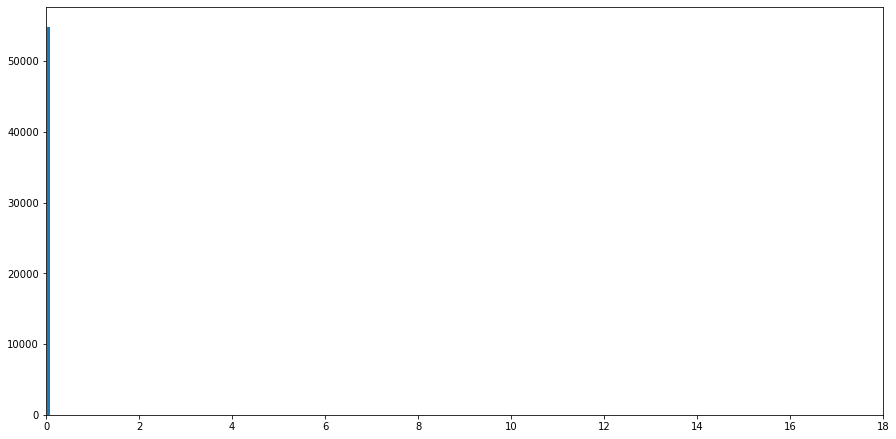

In [5]:
y_f[y_f < 4000] = 0.0

plt.bar(x, y_f, width = 0.05)
plt.xlim(0, 18)
plt.show()

Si hacemos la transformada inversa de dichas frecuencias filtradas debemos obtener una curva similar al coseno del que partíamos:

/home/zerjillo/anaconda3/envs/cursoAstronomia/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


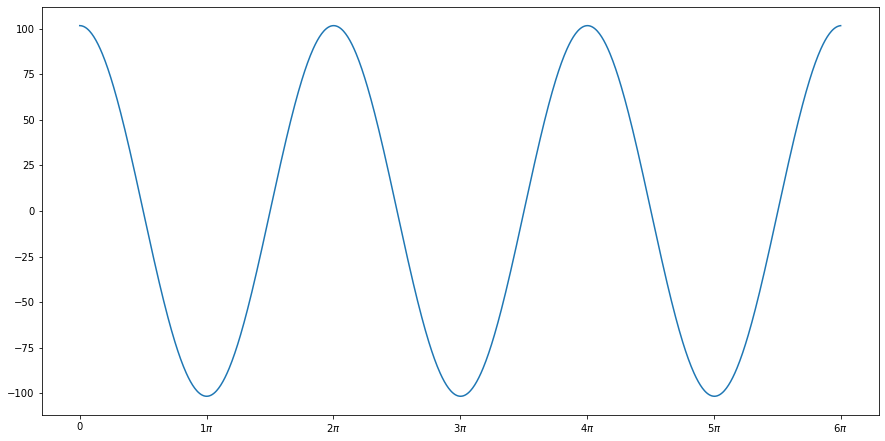

In [6]:
nuevaY = scipy.fft.ifft(y_f)

plt.Figure(figsize=(1, 1.5), dpi=80)
plt.plot(x, nuevaY)

ax = plt.gca()
ax.xaxis.set_major_formatter(FuncFormatter(
    lambda val, pos: '{:.0f}$\pi$'.format(val / np.pi) if val != 0 else '0'
))
ax.xaxis.set_major_locator(MultipleLocator(base=np.pi))


plt.savefig("salidas/reconstructed_sine.png", dpi=80)
plt.show()

Es interesante hacer notar que este tipo de supresiones de frecuencias poco relevantes es la base fundamental de muchos algoritmos de compresión de sonidos (`MP3`), imágenes (`JPG`) y vídeos (`MPEG`). Se recomienda jugar a eliminar menos frecuencias (bajando el umbral de `4000`) y veremos que la forma general de la curva se parece a la original. Sin embargo la información de dichas frecuencias se puede comprimir mucho porque hay muchas frecuencias a `0` que se pueden eliminar.

## Convoluciones

En matemáticas (en particular, análisis funcional), la convolución es una operación matemática en dos funciones $f$ y $g$  que produce una tercera función $f \ast g$. Se define como:
$$ f \ast g = \int_{-\infty}^{\infty} f(\tau) g(t+\tau)d\tau $$

En imagenes digitales aplicar una convolución es aplicar un filtro el cual  desenfoca una fotografía. 
Podemos usar este filtro para desenfocar el ruido.

`astropy.convolution` proporciona funciones y núcleos de convolución que ofrecen mejoras en comparación con las rutinas de convolución de `SciPy` `scipy.ndimage`, incluyendo:

+ Tratamiento adecuado de los valores `NaN` (ignorándolos durante la convolución y sustituyendo los píxeles `NaN` por valores interpolados).

+ Una única función para la convolución 1D, 2D y 3D

+ Opciones mejoradas para el tratamiento de los bordes

+ Versiones directas y de transformada rápida de Fourier (`FFT`)

+ Núcleos incorporados que se utilizan habitualmente en astronomía

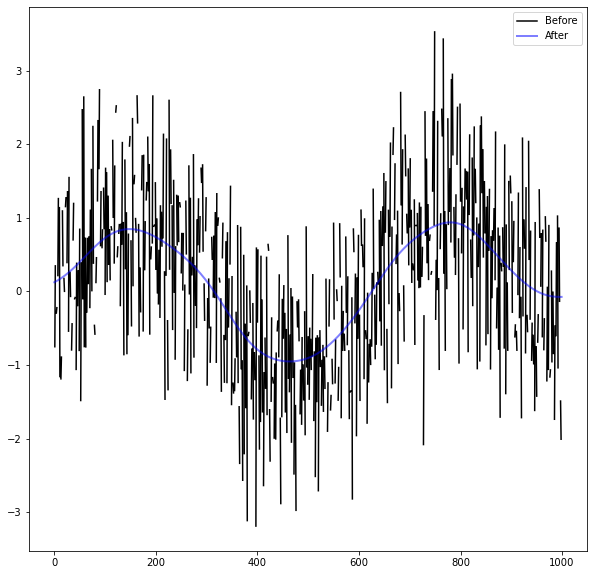

In [7]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.convolution import Gaussian1DKernel, convolve

plt.figure("Convolucion", figsize=[10, 10])
#plt.figure(3).clf()

# Generación de datos falsos
x = np.arange(1000).astype(float)
y = np.sin(x / 100.) + np.random.normal(0., 1., x.shape)
y[::3] = np.nan                                           # Cada tres posiciones metemos un NaN

# Creamos el núcleo
g = Gaussian1DKernel(stddev=50)

# Convolucion de los datos
z = convolve(y, g)

# Plot data before and after convolution
plt.plot(x, y, 'k-', label='Before')
plt.plot(x, z, 'b-', label='After', alpha=0.5, linewidth=2)
plt.legend(loc='best')
plt.show()

### Convolución sobre una imagen

Abrimos una imagen, en este caso será la imagen que hemos reducido anteriormente de la Nebulosa de la Tarántula.

In [8]:
from astropy.io import fits

ha=fits.open("imagenes/salidaImagenes/sho/imagenFinal_H-alpha.fit")[0].data

In [9]:
from astropy.convolution import convolve, convolve_fft
from astropy.convolution import Gaussian2DKernel

kernel = Gaussian2DKernel(x_stddev=1)
result = convolve(ha, kernel)

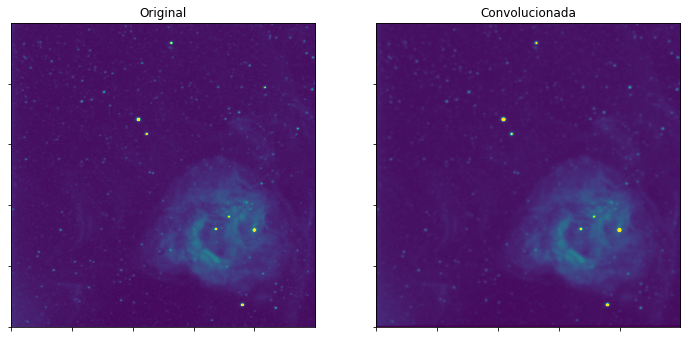

In [10]:
plt.figure(1, figsize=(12, 6)).clf()
plt.close(2) # close the second plot from above

ax1 = plt.subplot(1, 2, 1)
im = ax1.imshow(ha[0:500,0:500],vmin=np.min(ha[0:500,0:500]), vmax=np.median(ha[0:500,0:500])*1.5, origin='lower')


ax1.set_title("Original")
ax1.set_xticklabels([])
ax1.set_yticklabels([])

ax2 = plt.subplot(1, 2, 2)
im = ax2.imshow(result[0:500,0:500],vmin=np.min(ha[0:500,0:500]), vmax=np.median(ha[0:500,0:500])*1.5, origin='lower')
ax2.set_title("Convolucionada")
ax2.set_xticklabels([])
ax2.set_yticklabels([])
plt.show()

Podemos ver como varia el flujo en una región de nuestra imagen cuando aplicamos la convolución. Vemos como suaviza las zonas ruidosas disminuyendo su flujo. Por el contrario también disminuye las regiones donde tenemos nebulosa.

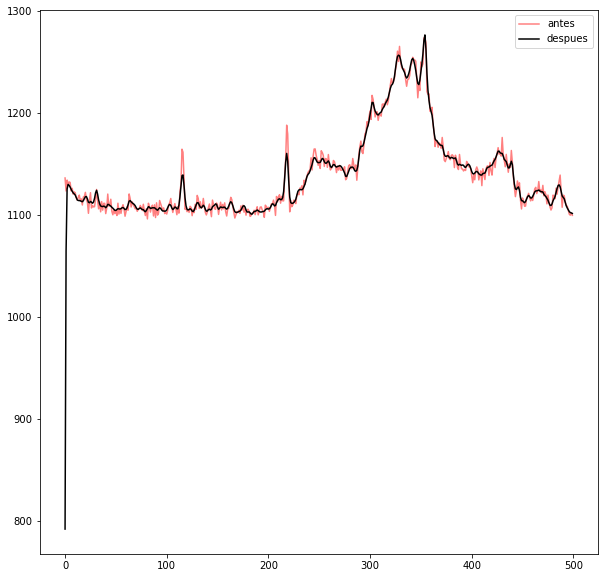

In [11]:
plt.figure("Ha", figsize=[10, 10])

plt.plot(np.arange(len(ha[100,0:500])), ha[100,0:500], 'r-', label='antes', alpha = 0.5)
plt.plot(np.arange(len(result[100,0:500])), result[100,0:500], 'k-', label='despues')

plt.legend(loc='best')
plt.show()

Para evitar que la eliminación de ruido afecte a las regiones brillantes podemos crear una máscara para solo coger el fondo donde la señal sea muy débil:

## Máscaras y convoluciones

Generamos una máscara con ``SigmaClip`` para seleccionar regiones muy oscuras 

In [12]:
from astropy.stats import SigmaClip

data = ha[0:500,0:500]
sigclip = SigmaClip(sigma=0.8, maxiters=2)
mask_data = sigclip(data)

In [13]:
mask_data.mask

array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ...,  True,  True, False],
       [ True,  True,  True, ..., False, False,  True],
       ...,
       [ True,  True,  True, ..., False, False,  True],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ...,  True, False, False]])

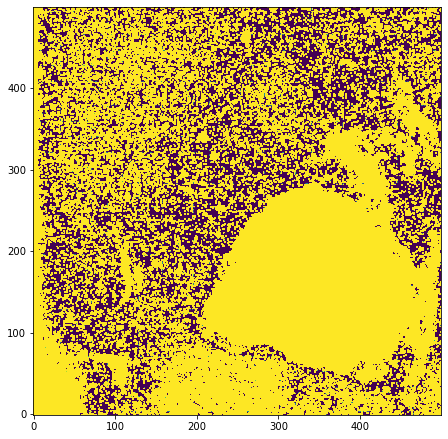

In [14]:
plt.imshow(mask_data.mask, vmin=0, vmax=0.001, origin = 'lower')

Añadimos la máscara a la convolución

In [15]:
result = convolve(data, kernel, mask = ~mask_data.mask)

Podemos generar también una convolución a través de una transformada de fourier.

In [16]:
result_fft = convolve_fft(data, kernel)

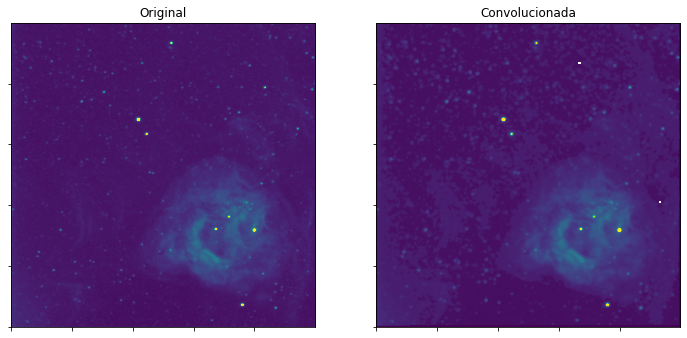

In [17]:
plt.figure(1, figsize=(12, 6)).clf()
plt.close(2) # close the second plot from above

ax1 = plt.subplot(1, 2, 1)
im = ax1.imshow(ha[0:500,0:500],vmin=np.min(ha), vmax=np.median(ha)*1.5, origin='lower')


ax1.set_title("Original")
ax1.set_xticklabels([])
ax1.set_yticklabels([])

ax2 = plt.subplot(1, 2, 2)
im = ax2.imshow(result,vmin=np.min(ha), vmax=np.median(ha)*1.5, origin='lower')
ax2.set_title("Convolucionada")
ax2.set_xticklabels([])
ax2.set_yticklabels([])
plt.show()

## Utilización de la convolución de `astropy` para sustituir los datos erróneos

Los métodos de convolución de `astropy` pueden utilizarse para sustituir los datos erroneos por valores interpolados de sus vecinos. La interpolación es útil para manejar imágenes con unos pocos píxeles malos.

In [18]:
from astropy.convolution import interpolate_replace_nans

result = interpolate_replace_nans(result, kernel)

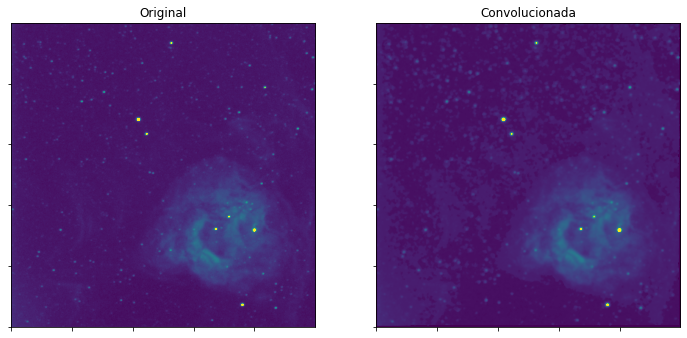

In [19]:
plt.figure(1, figsize=(12, 6)).clf()
plt.close(2) # close the second plot from above

ax1 = plt.subplot(1, 2, 1)
im = ax1.imshow(ha[0:500,0:500],vmin=np.min(ha), vmax=np.median(ha)*1.5, origin='lower')


ax1.set_title("Original")
ax1.set_xticklabels([])
ax1.set_yticklabels([])

ax2 = plt.subplot(1, 2, 2)
im = ax2.imshow(result,vmin=np.min(ha), vmax=np.median(ha)*1.5, origin='lower')
ax2.set_title("Convolucionada")
ax2.set_xticklabels([])
ax2.set_yticklabels([])
plt.show()